In [1]:
%matplotlib inline

from catboost import CatBoostRegressor
from collections import defaultdict
from gensim.models import word2vec, KeyedVectors
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pickle
import pymorphy2
import re
from scipy.stats import randint, reciprocal, expon, geom, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import urlextract

## Загрузка данных, немного EDA

In [25]:
df_train = pd.read_csv('./data/train_dataset_train/train_issues.csv')
df_test = pd.read_csv('./data/test_dataset_test/test_issues.csv')
df_train.head()

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI tests commissioned by ""Dobro Keiji"".",5,93,93,1800
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI tests of the ""Profile"" section.",5,93,93,7200
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI tests of the ""Personal Account"" section.",5,93,93,14400
3,819943,2019-10-01 06:02:49.000,SM-10682,"UI tests of the ""News"" section.",5,93,93,900
4,819941,2019-10-01 06:03:26.000,SM-10683,"UI tests of the ""Discount and surcharge zones""...",5,93,93,900


In [3]:
TARGET = 'overall_worklogs'
RANDOM_STATE = 29

In [4]:
comments_train = pd.read_csv('./data/train_dataset_train/train_comments.csv')
comments_train.head()

,comment_id,text,issue_id,author_id
0,11779,[https://www.youtube.com/watch?v=tuhOdtsvoNY|h...,669666,1
1,10601,OK [~accountid:557058:3f7ab89a-8969-4547-90df-...,669670,1
2,76101,I encountered a problem with access to `/users...,670930,2
3,76102,I have learned that `users/:id/emails` endpoin...,670930,2
4,76213,We have decided with Andrew to set member's em...,670930,2


In [28]:
empl = pd.read_csv('./data/AltGU/employees.csv')
empl.head()

,id,active,gender,full_name,position,hiring_type,payment_type,salary_calculation_type,english_level,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,1,1,1,David Courtney,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2,0,1,Dan Guerra,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0
2,4,0,1,Grady Smith,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0
3,6,0,1,James Powell,Разработчик мобильных приложений,staff,fixed,NaN,NaN,0,0,0,0,0
4,8,1,1,John Brown,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1


In [5]:
df_train.shape

(9589, 8)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9589 entries, 0 to 9588
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                9589 non-null   int64 
 1   created           9589 non-null   object
 2   key               9589 non-null   object
 3   summary           9589 non-null   object
 4   project_id        9589 non-null   int64 
 5   assignee_id       9589 non-null   int64 
 6   creator_id        9589 non-null   int64 
 7   overall_worklogs  9589 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 599.4+ KB


In [7]:
df_train.describe()

,id,project_id,assignee_id,creator_id,overall_worklogs
count,9.589000e+03,9589.000000,9589.000000,9589.000000,9.589000e+03
mean,7.265522e+05,17.493482,114.838461,117.467411,1.724369e+04
std,3.114348e+04,10.389579,125.497901,117.299165,9.864197e+04
min,6.696640e+05,5.000000,1.000000,1.000000,6.000000e+01
25%,7.225060e+05,13.000000,10.000000,11.000000,3.000000e+03
50%,7.256220e+05,13.000000,82.000000,82.000000,7.200000e+03
75%,7.287280e+05,13.000000,197.000000,193.000000,1.470000e+04
max,1.056012e+06,56.000000,384.000000,384.000000,7.014000e+06


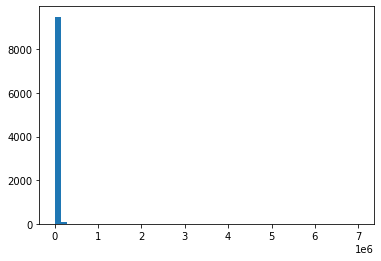

In [9]:
plt.hist(df_train[TARGET], bins=50);

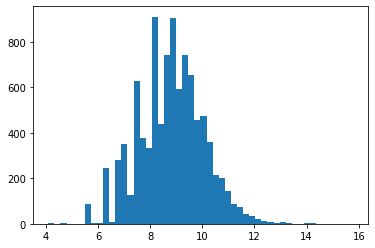

In [10]:
_ = plt.hist(np.log(df_train[TARGET]), bins=50)

## Задание классов обработки данных

### Обработка текстов

In [11]:
url_extractor = urlextract.URLExtract()

In [12]:
morph = pymorphy2.MorphAnalyzer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/shkin/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stops = set(stopwords.words('russian')) | set(stopwords.words('english'))

In [14]:
def text_to_wordlist(text, limit=None):
    if isinstance(text, str):
        text = re.sub('\w+@\w+\.\w+', ' EMAIL ', text)
        urls = list(set(url_extractor.find_urls(text)))
        for url in urls:
            text.replace(url, ' URL ')
        text_contents = re.sub('[^A-Za-zА-Яа-яёЁ]', ' ', text)
        words = text_contents.lower().split()
        words = [word for word in words if not word in stops]
        words = [morph.parse(word)[0].normal_form for word in words]
        if limit:
            words = words[:limit]
        return words
    else:
        return text

### Векторизация текста

In [15]:
class MeanVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, w2v_model, pretrained=False, is_tfidf=False, limit=None):
        self.w2v_model = w2v_model
        self.pretrained = pretrained
        self.pca = PCA(n_components=50, random_state=RANDOM_STATE)
        self.dim = None
        self.word2weight = None
        self.is_tfidf = is_tfidf
        self.tfidf = None
        self.limit = limit
        
    def fit(self, X, y=None):
        if self.pretrained:
            self.w2v_dict = dict(zip(self.w2v_model.index_to_key, self.w2v_model.vectors))
        else:
            self.w2v_dict = dict(zip(self.w2v_model.wv.index_to_key, self.w2v_model.wv.vectors))
        self.dim = len(next(iter(self.w2v_dict.values())))
        
        if self.is_tfidf:
            self.tfidf = TfidfVectorizer(analyzer=lambda x: x)
            self.tfidf.fit(X.apply(text_to_wordlist, limit=self.limit))
            max_idf = max(self.tfidf.idf_)
            self.word2weight = defaultdict(
                lambda: max_idf,
                [(w, self.tfidf.idf_[i]) for w, i in self.tfidf.vocabulary_.items()])
        
            vectors = np.array([
                np.mean([self.w2v_dict[w] * self.word2weight[w]
                     for w in words if w in self.w2v_dict] or
                    [np.zeros(self.dim)], axis=0)
                for words in X.apply(text_to_wordlist, limit=self.limit)
            ])
            
        else:
            vectors = np.array([
                np.mean([self.w2v_dict[word] for word in words if word in self.w2v_dict]
                    or [np.zeros(self.dim)], axis=0)
                for words in X.apply(text_to_wordlist, limit=self.limit)
            ])
        
        self.pca.fit(vectors)
        return self
    
    def transform(self, X):
        
        if self.is_tfidf:
            vectors = np.array([
                np.mean([self.w2v_dict[w] * self.word2weight[w]
                     for w in words if w in self.w2v_dict] or
                    [np.zeros(self.dim)], axis=0)
                for words in X.apply(text_to_wordlist, limit=self.limit)
            ])
        else:
            vectors = np.array([
                np.mean([self.w2v_dict[word] for word in words if word in self.w2v_dict]
                        or [np.zeros(self.dim)], axis=0)
                for words in X.apply(text_to_wordlist, limit=self.limit)
            ])
            
        return self.pca.transform(vectors)

### Выбор фичей для пайплайна

In [16]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X)

### Основной класс трансформации данных

In [17]:
class DataTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, w2v_model_text, w2v_model_comms, date_to_int=True):
        
        # Работа с таблицей сотрудников
        self.w2v_model_text = w2v_model_text
        self.w2v_model_comms = w2v_model_comms
        empl = pd.read_csv('./data/AltGU/employees.csv')
        self.empl_prepd = empl.copy()
        self.empl_prepd.drop(['full_name', 'salary_calculation_type', 'english_level'], axis=1, inplace=True)
        self.empl_prepd['hiring_type'].fillna('unknown', inplace=True)
        self.empl_prepd['payment_type'].fillna('unknown', inplace=True)
        self.empl_prepd['position'].fillna('unknown', inplace=True)
        self.date_to_int = date_to_int
        
        # Объединение различных формулировок должностей по группам
        web_devs = ['Web-разработчик', 'Ведущий web-разработчик', 'Руководитель команды разработки', 'Web-разработчик ']
        projects = ['Менеджер проектов', 'Ассистент менеджера проектов', 'офис-менеджер', 'Менеджер по тендерам', 'Ведущий менеджер проектов', 'Офис-менеджер']
        mob_devs = ['Разработчик мобильных приложений', 'разработчик мобильных приложений', 'ML-инженер', 'Руководитель команды разработки']
        dev_ops = ['Системный администратор (DevOps инженер)', 'DevOps инженер', 'Системный администратор', ' Системный администратор', 'Системный администратор(DevOps инженер)', 'DevOps engineer']
        miscs = ['Копирайтер', 'Консультант', 'seo-специалист', 'помощник бухгалтера', 'Бухгалтер']
        testers = ['Инженер-тестировщик', 'Инженер тестировщик (QA engineer)']
        designers = ['Web дизайнер', 'графический дизайнер', 'Web-дизайнер']
        markets = ['Delivery Manager', 'Руководитель отдела продаж', 'Руководитель отдела Маркетинга', 'Маркетолог', 'DM-политик']
        hrs = ['Сорсер', 'Ассистент HR-менеджера', 'Рекрутер', 'IT-рекрутер', 'Менеджер по персоналу (HR менеджер)', 'Руководитель отдела по управлению персоналом', 'Специалист по КДП', 'Специалист отдела по управлению персоналом']
        suits = ['Директор', 'Директор по стратегическому развитию', 'Руководитель отдела по управлению персоналом', 'Руководитель отдела Маркетинга', 'Руководитель отдела продаж', 'Ведущий менеджер проектов', 'Ведущий web-разработчик', 'Руководитель команды разработки', 'Директор по IT', 'Технический директор', 'Директор по качеству', 'Операционный директор']
        unspecified = ['unknown']

        # Превращение должностей в бинарные признаки
        self.empl_prepd['web_dev'] = 0
        self.empl_prepd['project'] = 0
        self.empl_prepd['mob_dev'] = 0
        self.empl_prepd['dev_ops'] = 0
        self.empl_prepd['miscs'] = 0
        self.empl_prepd['tester'] = 0
        self.empl_prepd['designer'] = 0
        self.empl_prepd['market'] = 0
        self.empl_prepd['hr'] = 0
        self.empl_prepd['suit'] = 0
        self.empl_prepd['job_unspec'] = 0
        
        self.empl_prepd.loc[self.empl_prepd['position'].isin(web_devs), 'web_dev'] = 1
        self.empl_prepd.loc[self.empl_prepd['position'].isin(projects), 'project'] = 1
        self.empl_prepd.loc[self.empl_prepd['position'].isin(mob_devs), 'mob_dev'] = 1
        self.empl_prepd.loc[self.empl_prepd['position'].isin(dev_ops), 'dev_ops'] = 1
        self.empl_prepd.loc[self.empl_prepd['position'].isin(miscs), 'miscs'] = 1
        self.empl_prepd.loc[self.empl_prepd['position'].isin(testers), 'tester'] = 1
        self.empl_prepd.loc[self.empl_prepd['position'].isin(designers), 'designer'] = 1
        self.empl_prepd.loc[self.empl_prepd['position'].isin(markets), 'market'] = 1
        self.empl_prepd.loc[self.empl_prepd['position'].isin(hrs), 'hr'] = 1
        self.empl_prepd.loc[self.empl_prepd['position'].isin(suits), 'suit'] = 1
        self.empl_prepd.loc[self.empl_prepd['position'].isin(unspecified), 'job_unspec'] = 1
        self.empl_prepd.drop('position', axis=1, inplace=True)
    
        # Компоновка фичей для пайплайна
        self.cat_features = ['project_id', 'assignee_id', 'creator_id', 'hiring_type', 'payment_type', 
                             'hiring_type_y2', 'payment_type_y2']
        self.text_feature = 'summary'
        self.com_feature = 'text'
        self.just_features = None
        self.feat_pipeline = None

    # Прикрепление комментариев
    def expand_with_comments(self, X, comments):
        comments[self.com_feature] += ' '
        X_expanded = pd.merge(X, comments.groupby('issue_id', sort=False).agg({self.com_feature: ['sum', 'count']})\
                              .droplevel(0, axis=1).rename(columns={'sum': 'text', 'count': 'n_comms'}), 
                                     how='left', left_on='id', right_on='issue_id')
        X_expanded.index = X.index
        X_expanded[self.com_feature].fillna('0', inplace=True)
        X_expanded['n_comms'].fillna(0, inplace=True)
        X_expanded['n_comms'] = X_expanded['n_comms'].astype(int)
        X_expanded['self_assigned'] = 0
        X_expanded.loc[X_expanded['assignee_id'] == X_expanded['creator_id'], 'self_assigned'] = 1

        return X_expanded
    
    # Прикрепление таблицы сотрудников
    def expand_with_employees(self, X):
        X_expanded = pd.merge(X, self.empl_prepd, how='left', left_on='assignee_id', right_on='id', suffixes=(None, '_y1'))
        X_expanded = pd.merge(X_expanded, self.empl_prepd, how='left', left_on='creator_id', right_on='id', suffixes=(None, '_y2'))
        X_expanded.index = X.index
        return X_expanded

    # Общая функция подготовки данных
    def prepare_data(self, X, test):
        comments_path = './data/test_dataset_test/test_comments.csv' if test else './data/train_dataset_train/train_comments.csv'
        comments = pd.read_csv(comments_path)
        X_expanded = self.expand_with_comments(X, comments=comments)
        X_final = self.expand_with_employees(X_expanded)
        if self.date_to_int:
            X_final['created'] = pd.to_datetime(X_final['created']).astype(int) / 10**9
        else:
            X_final['created'] = pd.to_datetime(X_final['created'])
        return X_final
    
    
    # Обучение пайплайна признаков
    def fit(self, X, y=None):
        
        X_final = self.prepare_data(X, test=False)
        self.just_features = list(set(X_final.columns) - set(X.columns) - set(self.cat_features) - {'id_y1', 'id_y2', 'text'})
        self.just_features += ['created']
        
        self.feat_pipeline = ColumnTransformer([
            ('cat', OneHotEncoder(handle_unknown='ignore'), self.cat_features),
            ('text', MeanVectorizer(self.w2v_model_text, pretrained=True, is_tfidf=True), self.text_feature),
            ('comms', MeanVectorizer(self.w2v_model_comms, pretrained=False), self.com_feature),
            ('just_select', FeatureSelector(), sorted(self.just_features))
        ])
        
        self.feat_pipeline.fit(X_final)
        
        return self
    
    # Трансформация данных, возвращение датафрейма с названиями колонок
    def transform(self, X, test=False):
        
        X_prepared = self.prepare_data(X, test=test)
        X_transformed = self.feat_pipeline.transform(X_prepared)
        
        feats1 = list(self.feat_pipeline.transformers_[0][1].get_feature_names_out(self.cat_features))
        feats2 = [f'text_value_{i}' for i in range(1, min(self.feat_pipeline.transformers_[1][1].w2v_model.vector_size, 50) + 1)]
        feats3 = [f'comms_value_{i}' for i in range(1, min(self.feat_pipeline.transformers_[2][1].w2v_model.vector_size, 50) + 1)]
        feats4 = sorted(list(self.just_features))
        
        return pd.DataFrame(X_transformed, columns=feats1 + feats2 + feats3 + feats4, index=X.index)

## Обучение моделей

### Использование предобученной модели word2vec на текстах задач

Ссылка на скачивание модели:  
https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

In [18]:
w2v_model_text = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

### Обучение другой модели word2vec на текстах комментариев

Для точного воспроизведения полученных мной результатов необходимо  
до запуска ноутбука выставить значение переменной окружения PYTHONHASHSEED  
в значение 29. Иначе модель word2vec обучится по-другому!

In [19]:
comments_test = pd.read_csv('./data/test_dataset_test/test_comments.csv')

In [21]:
w2v_model_comms = word2vec.Word2Vec(pd.concat((comments_train['text'], comments_test['text']), axis=0).apply(text_to_wordlist), window=2, seed=RANDOM_STATE, workers=1, vector_size=200)

### Трансформируем данные, запускаем обучение

In [22]:
transformer = DataTransformer(w2v_model_text, w2v_model_comms, date_to_int=False)

In [23]:
df_train_transformed = transformer.fit_transform(df_train)

In [26]:
df_test_transformed = transformer.transform(df_test, test=True)

### CatBoost

In [ ]:
param_distribs = {
        'iterations': randint(low=10, high=800),
        'learning_rate': reciprocal(1e-5, 1.0),
        'depth': [3, 4, 5, 6],
        'l2_leaf_reg': randint(low=1, high=10),
        'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise'],
        'min_data_in_leaf': geom(0.1)
    }

for seed in range(10):

    split = KFold(n_splits=5, shuffle=True, random_state=seed)

    model = RandomizedSearchCV(CatBoostRegressor(random_state=seed, verbose=0), 
                               param_distributions=param_distribs, refit=False,
                               n_iter=50, cv=split, scoring='r2', random_state=seed, n_jobs=4)
    model.fit(df_train_transformed, df_train[TARGET])
    
    idx = np.argmax(model.cv_results_['mean_test_score'] - model.cv_results_['std_test_score'])
    best_params = model.cv_results_['params'][idx]
    
    model = CatBoostRegressor(random_state=seed, **best_params)
    model.fit(df_train_transformed, df_train[TARGET], verbose=0)

    y_pred = model.predict(df_test_transformed)
    submit = pd.read_csv('./data/AltGU/sample_solution.csv')
    submit[TARGET] = y_pred
    submit.to_csv(f'./models/cb_regressor/submit_{seed+1}.csv', index=False)
    with open(f'./models/cb_regressor/cb_model_{seed+1}.pkl', 'wb') as f:
        pickle.dump(model, f)

In [6]:
for i in range(1, 11):
    exec(f'y_pred_{i} = pd.read_csv("./models/cb_regressor/submit_{i}.csv")[TARGET].values')

In [7]:
y_preds_cb = np.mean([y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5, 
                   y_pred_6, y_pred_7, y_pred_8, y_pred_9, y_pred_10], axis=0)

In [56]:
pd.Series(y_preds_cb).to_csv('./models/cb_regressor/cb_submit_mean.csv', index=False)

### CatBoost log

In [ ]:
param_distribs = {
        'iterations': randint(low=10, high=800),
        'learning_rate': reciprocal(1e-5, 1.0),
        'depth': [3, 4, 5, 6],
        'l2_leaf_reg': randint(low=1, high=10),
        'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise'],
        'min_data_in_leaf': geom(0.1)
    }

for seed in range(10):

    split = KFold(n_splits=5, shuffle=True, random_state=seed)

    model = RandomizedSearchCV(CatBoostRegressor(random_state=seed, verbose=0), 
                               param_distributions=param_distribs, refit=False,
                               n_iter=50, cv=split, scoring='r2', random_state=seed, n_jobs=4)
    model.fit(df_train_transformed, np.log(df_train[TARGET]))
    
    idx = np.argmax(model.cv_results_['mean_test_score'] - model.cv_results_['std_test_score'])
    best_params = model.cv_results_['params'][idx]
    
    model = CatBoostRegressor(random_state=seed, **best_params)
    model.fit(df_train_transformed, np.log(df_train[TARGET]), verbose=0)

    y_pred = np.exp(model.predict(df_test_transformed))
    submit = pd.read_csv('./data/AltGU/sample_solution.csv')
    submit[TARGET] = y_pred
    submit.to_csv(f'./models/cb_log_regressor/cb_l_submit_{seed+1}.csv', index=False)
    with open(f'./models/cb_log_regressor/cb_l_model_{seed+1}.pkl', 'wb') as f:
        pickle.dump(model, f)

In [6]:
for i in range(1, 11):
    exec(f'y_pred_{i} = pd.read_csv("./models/cb_log_regressor/cb_l_submit_{i}.csv")[TARGET].values')

In [7]:
y_preds_cb_log = np.mean([y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5, 
                   y_pred_6, y_pred_7, y_pred_8, y_pred_9, y_pred_10], axis=0)

In [56]:
pd.Series(y_preds_cb_log).to_csv('./models/cb_log_regressor/cb_l_submit_mean.csv', index=False)

### LightGBM log

In [25]:
transformer_2 = DataTransformer(w2v_model_text, w2v_model_comms, date_to_int=True)

In [26]:
df_train_transformed = transformer_2.fit_transform(df_train)

In [27]:
df_test_transformed = transformer_2.transform(df_test, test=True)

In [ ]:
param_distribs = {
        'n_estimators': randint(low=10, high=800),
        'learning_rate': reciprocal(1e-4, 1.0),
        'num_leaves': randint(low=10, high=50),
        'reg_lambda': expon(scale=1.0),
        'reg_alpha': expon(scale=1.0),
        'min_child_samples': geom(0.05)
    }

for seed in range(10):

    split = KFold(n_splits=5, shuffle=True, random_state=seed)

    model = RandomizedSearchCV(LGBMRegressor(random_state=seed), 
                               param_distributions=param_distribs, refit=False,
                               n_iter=50, cv=split, scoring='r2', random_state=seed, n_jobs=4)
    model.fit(df_train_transformed, np.log(df_train[TARGET]))
    
    idx = np.argmax(model.cv_results_['mean_test_score'] - model.cv_results_['std_test_score'])
    best_params = model.cv_results_['params'][idx]
    
    model = LGBMRegressor(random_state=seed, **best_params)
    model.fit(df_train_transformed, np.log(df_train[TARGET]))

    y_pred = np.exp(model.predict(df_test_transformed))
    submit = pd.read_csv('./data/AltGU/sample_solution.csv')
    submit[TARGET] = y_pred
    submit.to_csv(f'./models/lgbm_log/lgbm_log_submit_{seed+1}.csv', index=False)
    with open(f'./models/lgbm_log/lgbm_log_model_{seed+1}.pkl', 'wb') as f:
        pickle.dump(model, f)

In [8]:
for i in range(1, 11):
    exec(f'y_pred_{i} = pd.read_csv("./models/lgbm_log/lgbm_log_submit_{i}.csv")[TARGET].values')

In [9]:
y_preds_lgbm_log = np.mean([y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5, 
                   y_pred_6, y_pred_7, y_pred_8, y_pred_9, y_pred_10], axis=0)

In [43]:
pd.Series(y_preds_lgbm_log).to_csv('./models/lgbm_log/lgbm_log_submit_mean.csv', index=False)

In [10]:
y_preds_final = np.mean([y_preds_lgbm_log, y_preds_cb, y_preds_cb_log], axis=0)

## Test submit

In [12]:
submit = pd.read_csv('./data/AltGU/sample_solution.csv')

In [13]:
submit[TARGET] = y_preds_final

In [14]:
submit.to_csv('./submission_final.csv', index=False)